<a href="https://colab.research.google.com/github/Marytem/Lane_detection/blob/master/unet_lane_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ideas&TODOs

* add augmentation

In [0]:
from google.colab import drive
drive.mount('/content/drive')   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import model
import DataGenerator

import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.backend as K
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.utils import Sequence

Using TensorFlow backend.


### Data generation

In [0]:
data_dir = '/content/drive/My Drive/lane data/segm_structure/'

In [0]:
class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, image_path, mask_path,
                 to_fit=True, batch_size=8, dim=(256, 256),
                 n_channels=1, n_classes=1, shuffle=True):
        """Initialization
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.image_path = image_path
        self.mask_path = mask_path
        self.img_labels = os.listdir(self.image_path)
        self.mask_labels = os.listdir(self.mask_path)
        self.img_labels.sort(key=lambda f: [int(s) for s in f[:-4].split('_') if s.isdigit()][0])
        self.mask_labels.sort(key=lambda f: [int(s) for s in f[:-4].split('_') if s.isdigit()][0])
        self.list_IDs = list(range(len(self.img_labels)))
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X = self._generate_X(list_IDs_temp)
        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        grayscale = self.n_channels == 1
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            x = self._load_image(self.image_path + self.img_labels[ID], grayscale=grayscale)
            X[i,] = np.reshape(x, (self.dim[0], self.dim[1], self.n_channels))

        return X

    def _generate_y(self, list_IDs_temp):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        grayscale = self.n_classes==1
        Y = np.empty((self.batch_size, *self.dim, 1), dtype=int)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # y[i,] = self._load_grayscale_image(self.mask_path + self.mask_labels[ID])
            y = self._load_image(self.mask_path + self.mask_labels[ID], grayscale=grayscale)
            Y[i,] = np.reshape(y, (self.dim[0], self.dim[1], self.n_classes))
        return Y

    def _load_image(self, image_path, grayscale=False):
        """Load grayscale image
        :param image_path: path to image to load
        :return: loaded image
        """
        img = cv2.imread(image_path)
        if grayscale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, dsize=self.dim, interpolation=cv2.INTER_CUBIC)
        img = img / 255
        return img

### Train

In [0]:
NO_OF_TRAINING_IMAGES = len(os.listdir(data_dir + 'train_fr/train/'))
NO_OF_VAL_IMAGES = len(os.listdir(data_dir + 'val_fr/val/'))
NO_OF_EPOCHS = 40
BATCH_SIZE = 8

train_generator = DataGenerator(data_dir+'train_fr/train/',
                                data_dir+'train_masks/train/',
                                batch_size=BATCH_SIZE)
val_generator = DataGenerator(data_dir+'val_fr/val/',
                              data_dir+'val_masks/val/',
                              batch_size=BATCH_SIZE)
weights_path = 'weights/easy/'
opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
m = model.unet()
# m.compile(loss=focal_loss, optimizer=opt, metrics=[dice_coef])
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

checkpoint = ModelCheckpoint(weights_path, 
                             monitor=dice_coef, 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')
csv_logger = CSVLogger('./log.out',
                       append=True,
                       separator=';')
earlystopping = EarlyStopping(monitor =dice_coef,
                              verbose = 1,
                              min_delta = 0.01,
                              patience = 3,
                              mode = 'max')
callbacks_list = [checkpoint, csv_logger, earlystopping]
train_steps = math.ceil(len(train_generator) / train_generator.batch_size)
val_steps = math.ceil(len(val_generator) / val_generator.batch_size)

In [0]:
results = m.fit_generator(train_generator, 
                          epochs=NO_OF_EPOCHS, 
                          validation_data=val_generator, 
                          validation_steps=val_steps,
                          steps_per_epoch=train_steps,
                          )

Epoch 1/40
51/51 [==============================] - 73s 1s/step - loss: 0.0299 - acc: 0.9869 - val_loss: 0.0310 - val_acc: 0.9870
Epoch 2/40
51/51 [==============================] - 72s 1s/step - loss: 0.0297 - acc: 0.9872 - val_loss: 0.0324 - val_acc: 0.9861
Epoch 3/40
51/51 [==============================] - 72s 1s/step - loss: 0.0296 - acc: 0.9872 - val_loss: 0.0296 - val_acc: 0.9873
Epoch 4/40
51/51 [==============================] - 72s 1s/step - loss: 0.0292 - acc: 0.9872 - val_loss: 0.0317 - val_acc: 0.9868
Epoch 5/40
51/51 [==============================] - 72s 1s/step - loss: 0.0292 - acc: 0.9872 - val_loss: 0.0308 - val_acc: 0.9868
Epoch 6/40
51/51 [==============================] - 72s 1s/step - loss: 0.0295 - acc: 0.9872 - val_loss: 0.0308 - val_acc: 0.9866
Epoch 7/40
51/51 [==============================] - 72s 1s/step - loss: 0.0295 - acc: 0.9871 - val_loss: 0.0293 - val_acc: 0.9876
Epoch 8/40
51/51 [==============================] - 72s 1s/step - loss: 0.0298 - acc: 0.98

KeyboardInterrupt: ignored

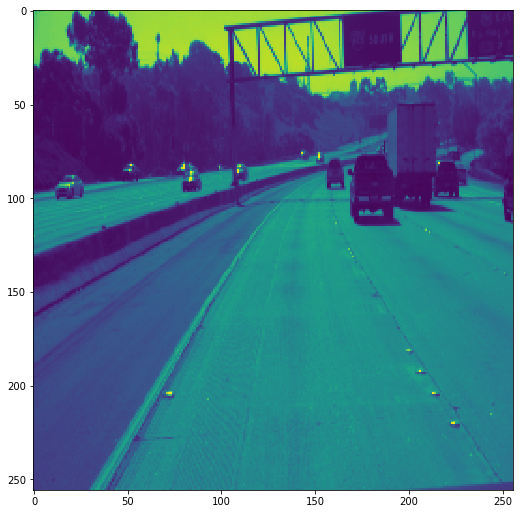

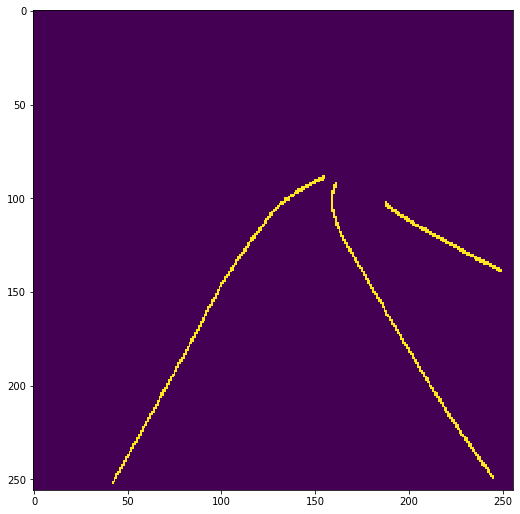

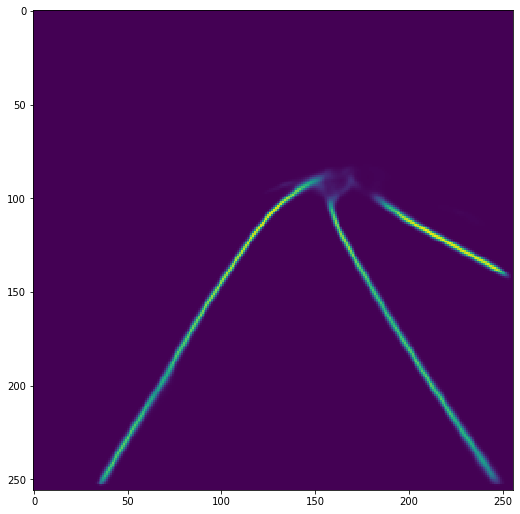

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
def display_images(images, cmap=None):
    plt.figure(figsize=(30,30))
    for i, image in enumerate(images):
        plt.subplot(3,2,i+1)
        plt.imshow(image, cmap)
        plt.autoscale(tight=True)
    plt.show()


batch_ind = 16
pred = m.predict(val_generator[batch_ind][0])[3]
img = val_generator[batch_ind][0][3]
mask = val_generator[batch_ind][1][3]

display_images([np.reshape(img, (256,256))])
display_images([np.reshape(mask, (256,256))])
display_images([np.reshape(pred, (256,256))])
plt.show()

In [0]:
m.save('Model.h5')

### Metrics (so far not relevant)

In [0]:
def focal_loss(y_true, y_pred, gamma=2., alpha=.25):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

### Other model and train(so far not relevant)

In [0]:
NO_OF_TRAINING_IMAGES = len(os.listdir(data_dir + 'train_fr/train/'))
NO_OF_VAL_IMAGES = len(os.listdir(data_dir + 'val_fr/val/'))
NO_OF_EPOCHS = 40
BATCH_SIZE = 8
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [0]:
from keras.layers import Input

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

m2 = Model(inputs=[inputs], outputs=[outputs])
m2.compile(loss=focal_loss, optimizer=opt, metrics=[dice_coef])
# m2.summary()

In [0]:
train_generator = DataGenerator(data_dir+'train_fr/train/', 
                                data_dir+'train_masks/train/',
                                batch_size=BATCH_SIZE,
                                dim=(IMG_HEIGHT, IMG_WIDTH),
                                n_channels=IMG_CHANNELS)
val_generator = DataGenerator(data_dir+'val_fr/val/',
                              data_dir+'val_masks/val/',
                              batch_size=BATCH_SIZE,
                              dim=(IMG_HEIGHT, IMG_WIDTH),
                              n_channels=IMG_CHANNELS)
weights_path = 'weights/easy/'

In [0]:
checkpoint = ModelCheckpoint(weights_path, monitor=dice_coef, 
                             verbose=True, save_best_only=True, mode='max')

csv_logger = CSVLogger('./log.out', append=True, separator=';')
earlystopping = EarlyStopping(monitor =dice_coef, verbose = 1,
                              min_delta = 0.01, patience = 3, mode = 'max')
callbacks_list = [checkpoint, csv_logger, earlystopping]
results = m2.fit_generator(train_generator, epochs=NO_OF_EPOCHS, 
                          steps_per_epoch = (NO_OF_TRAINING_IMAGES//BATCH_SIZE),
                          validation_data=val_generator, 
                          validation_steps=(NO_OF_VAL_IMAGES//BATCH_SIZE), 
                          callbacks=callbacks_list)